In [11]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import theano 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
%matplotlib inline
import myutil

In [2]:
import importlib
_ = importlib.reload(myutil)

## Get data and take first look at dataset

In [3]:
dfx = myutil.get_indexed_dataset('data/dengue_features_train.csv')
dfy = myutil.get_indexed_dataset('data/dengue_labels_train.csv')
dftrain = myutil.set_index(pd.merge(dfx, dfy))
dftrain.sort_index(axis=0, inplace=True)
dftrain.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
yearweekofyear,,,,,,,,,,,,,,,,,,,,,
199018,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
199019,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
199020,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
199021,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
199022,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [4]:
dftrain.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [5]:
dftrain.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

## Split data - will model separately for each city

In [6]:
dftrain.dropna(inplace=True)
dftrain_iq, dftrain_sj = myutil.split_dataset_by_city(dftrain)

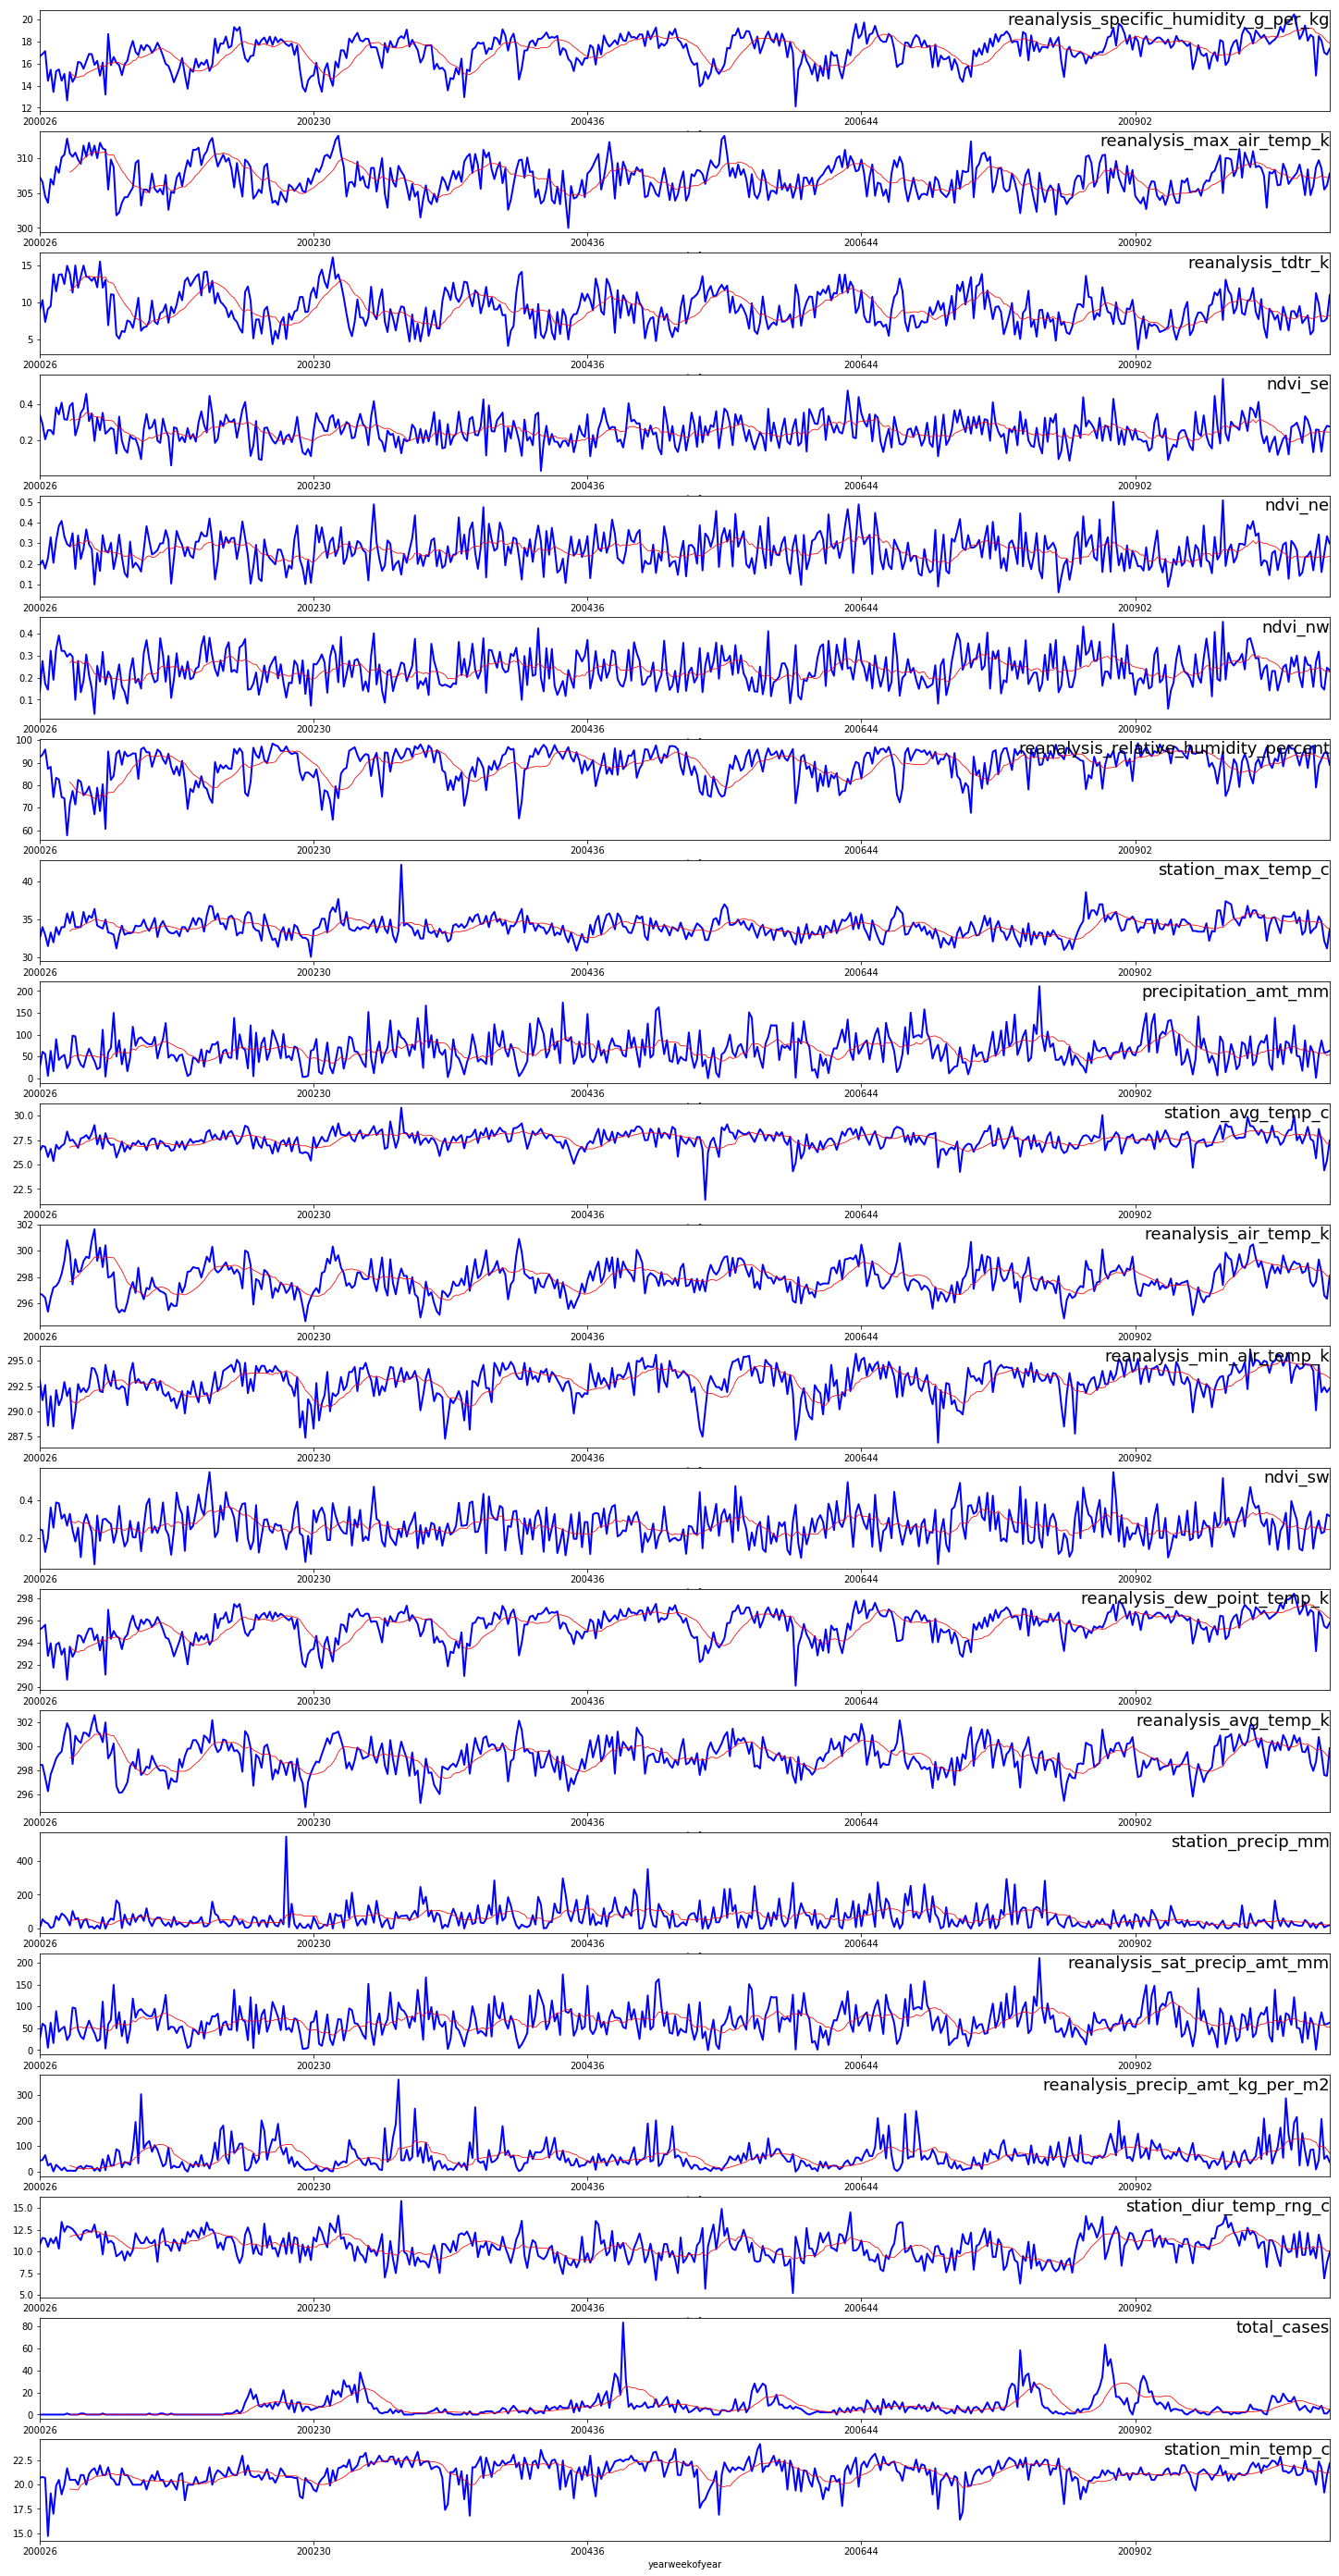

In [7]:
myutil.plot_cols2(dftrain_iq)

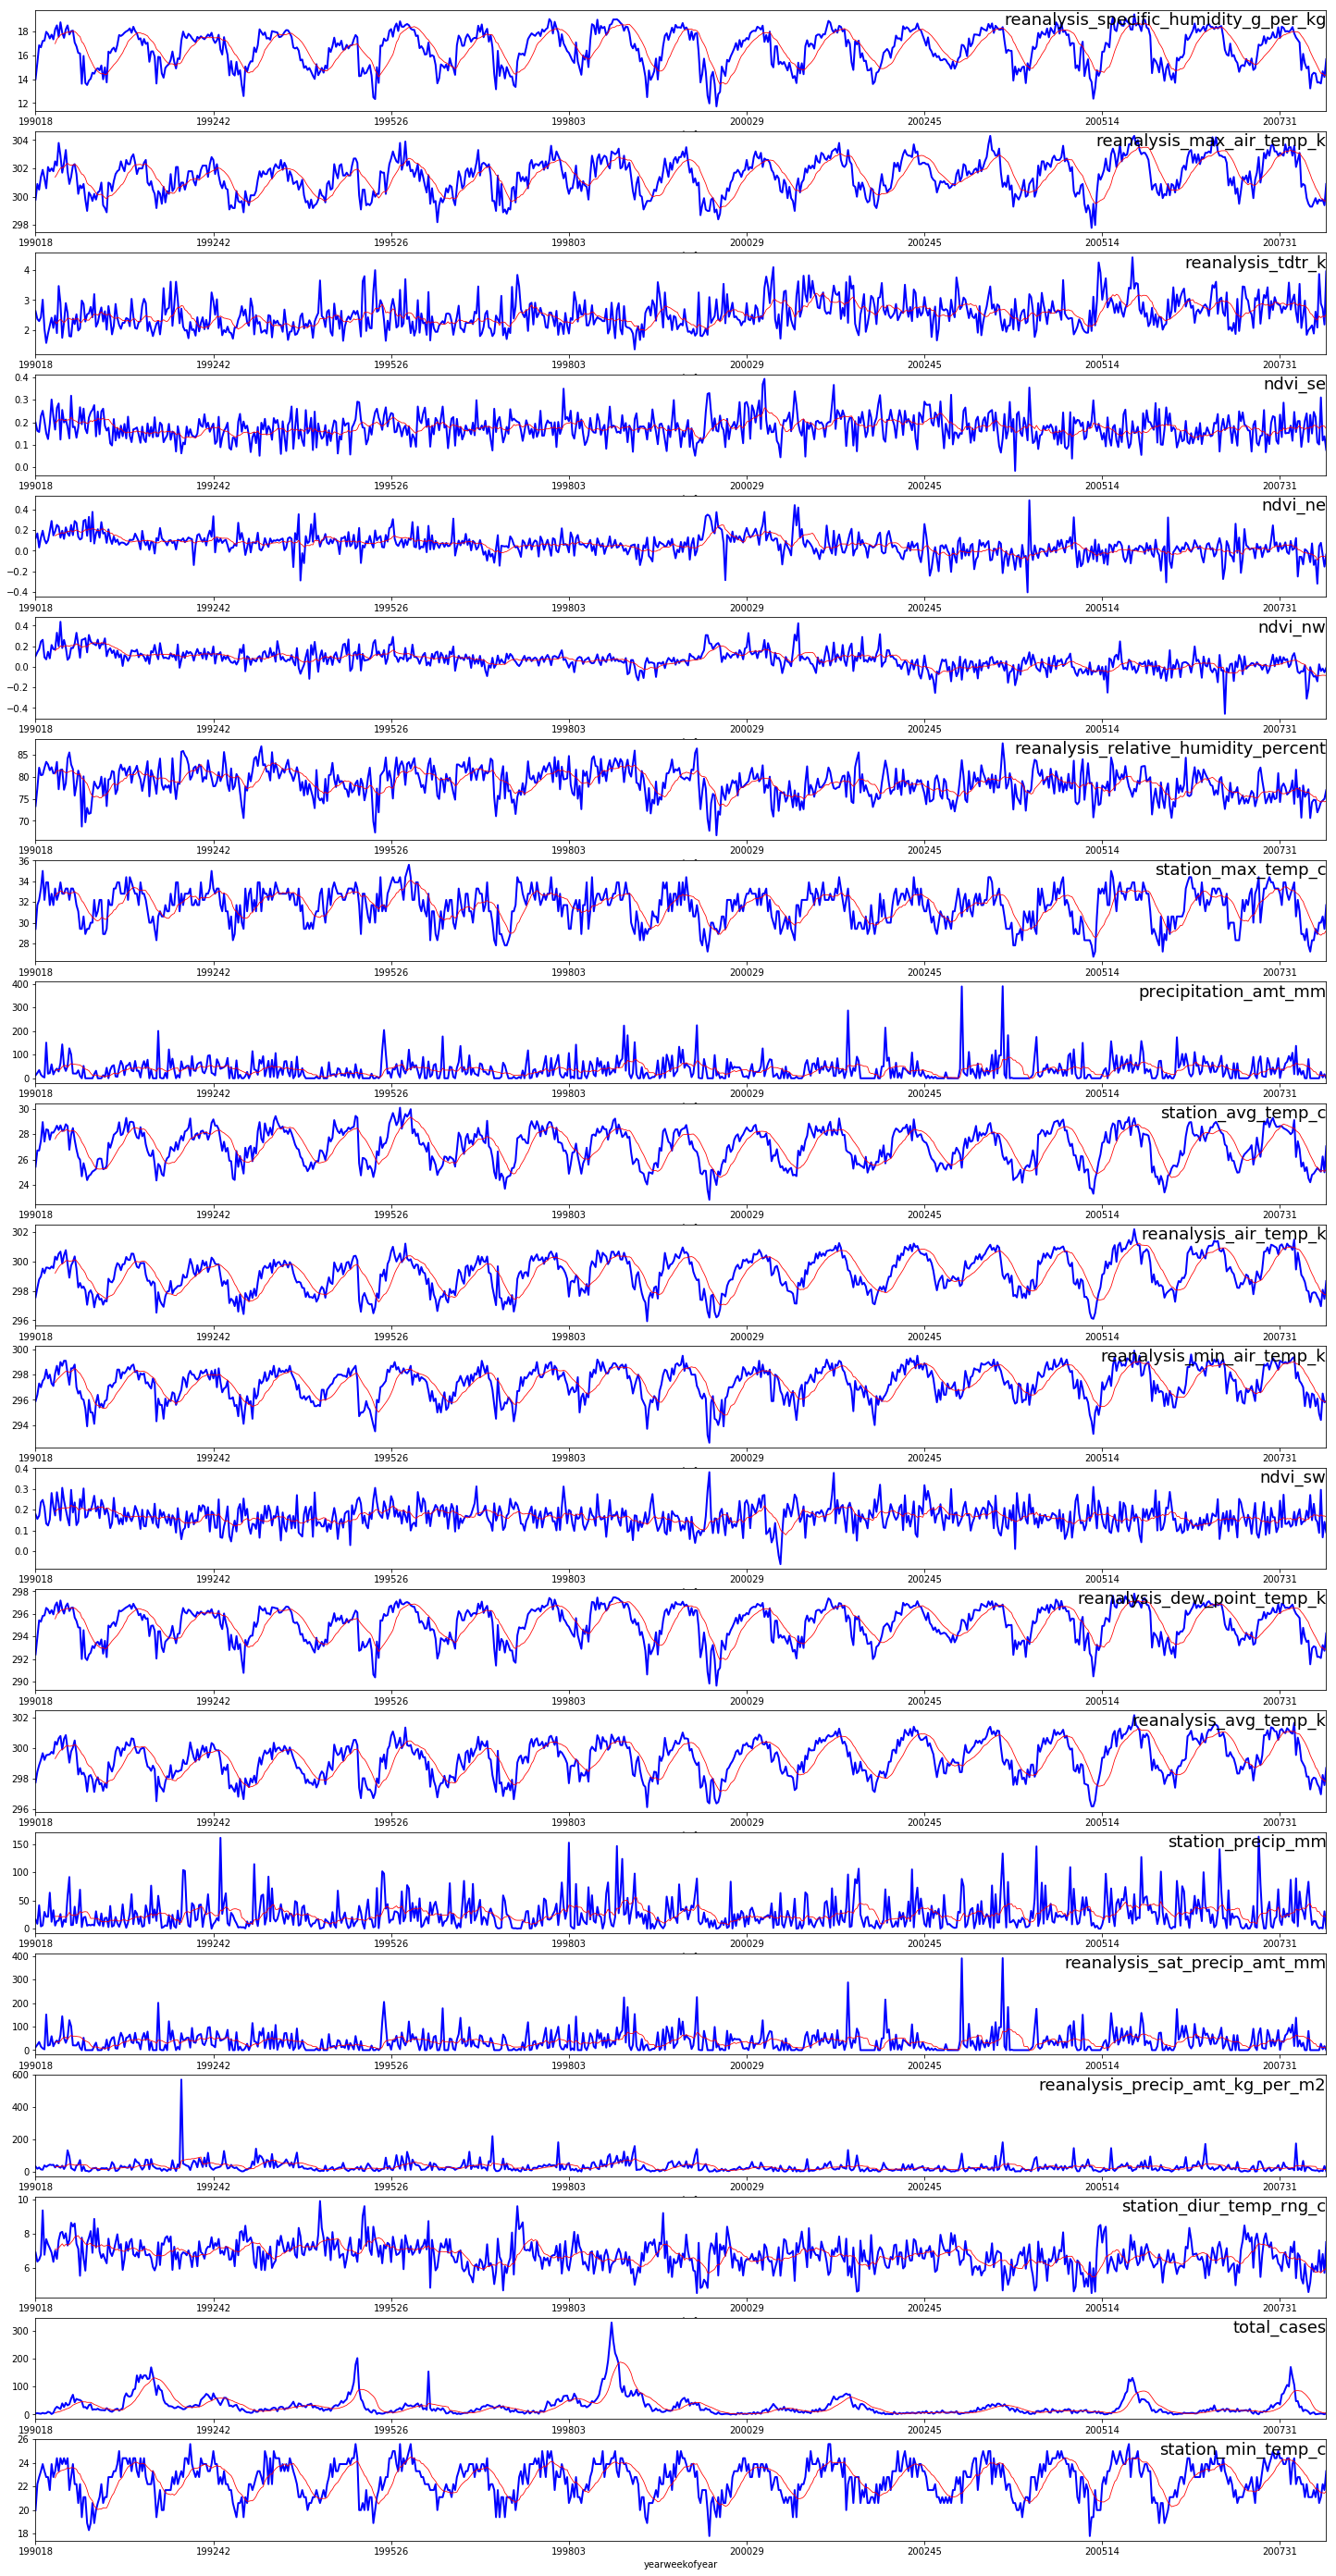

In [8]:
myutil.plot_cols2(dftrain_sj)

## Preprocess each dataset
From the plots and counts we notice:
1. There are plenty gaps and NaNs in the datasets
2. There is seasonality and some trending in the data, but we will ignore the trend

**Pre-processing steps are:**
1. Remove columns city, year, weekofyear and week_start_date
2. Interpolate to fill all NaNs
3. Convert data to np array of type float64
4. Normalize all features
5. Shift labels by number of weeks passed as parameter, signifying dengue incubation period
<BR>

In [63]:
# split dataset into test and validation partitions
def prep_LSTM_run(city_data, timesteps):
    
    X = city_data[:,:-1]
    y = city_data[:,-1]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # LSTM exped 3D input of the form [no_samples, timesteps, no_features] 
    X_train = X_train.reshape(X_train.shape[0], timesteps, int(X_train.shape[1]/timesteps))
    X_valid = X_valid.reshape(X_valid.shape[0], timesteps, int(X_valid.shape[1]/timesteps))
    
    return X_train, X_valid, y_train, y_valid


def LSTM_run(nptrain, timesteps=1, epochs=50, batch_size=32, exploring=False):
    
    # create partitions for training
    X_train, X_valid, y_train, y_valid = prep_LSTM_run(nptrain, timesteps)
    if exploring: print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    # build graph
    model = Sequential()
    model.add(LSTM(X_train.shape[1]*X_train.shape[2]+1, return_sequences=True,\
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(X_train.shape[2]+1))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='adam')  # 'rmsprop'
    # fit net
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_valid, y_valid), verbose=0, shuffle=False)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    
    if exploring:
        print("Final loss train: {}".format(history.history['loss'][-1]))
        print("Final loss valid: {}".format(history.history['val_loss'][-1]))

    plt.legend()
    plt.show()
    
    return model

# Get test dataset, create predictions and save them in the proper submission file format
def LSTM_predict_and_save(df_iq, model_iq, ts_iq, df_sj, model_sj, ts_sj, filename):

    # create prediction vectors for iquito and san juan
    dftest = myutil.get_indexed_dataset('data/dengue_features_test.csv')
    dftest_iq, dftest_sj = myutil.split_dataset_by_city(dftest)
    nptest_iq = myutil.preprocess_test(df_iq.copy(), dftest_iq, ts_iq)
    nptest_sj = myutil.preprocess_test(df_sj.copy(), dftest_sj, ts_sj)

    yhat_iq = model_iq.predict(nptest_iq.reshape(nptest_iq.shape[0], ts_iq, int(nptest_iq.shape[1]/ts_iq)))
    yhat_sj = model_sj.predict(nptest_sj.reshape(nptest_sj.shape[0], ts_sj, int(nptest_sj.shape[1]/ts_sj)))
    
    #print(yhat_iq.shape)
    #print(yhat_sj.shape)

    dfsubm = pd.read_csv('data/submission_format.csv')
    npsubm_sj = np.concatenate((dfsubm[dfsubm['city']=='sj'][['city','year','weekofyear']].values, \
                                yhat_sj.round().astype('int64')), axis=1)
    npsubm_iq = np.concatenate((dfsubm[dfsubm['city']=='iq'][['city','year','weekofyear']].values, \
                                yhat_iq.round().astype('int64')), axis=1)
    dfresults = pd.DataFrame(np.concatenate((npsubm_sj, npsubm_iq), axis=0), columns=dfsubm.columns)
    dfresults.to_csv(filename, index=False)
    

(376, 2, 20) (94, 2, 20) (376,) (94,)
Final loss train: 5.953863874394843
Final loss valid: 5.956281530096176


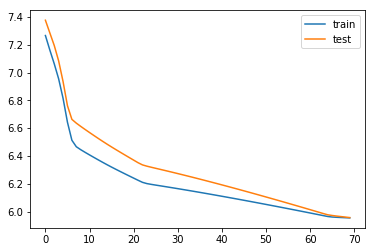

In [50]:
periods_iq = 2
nptrain_iq = myutil.preprocess(dftrain_iq.copy(), periods_iq)
model_iq = LSTM_run(nptrain_iq, timesteps=periods_iq, epochs=70, batch_size=32, exploring=True)

(562, 24, 20) (141, 24, 20) (562,) (141,)
Final loss train: 22.08064015480123
Final loss valid: 22.280718918387773


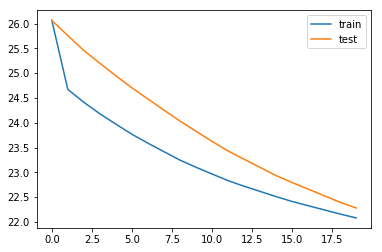

In [64]:
periods_sj = 24
nptrain_sj = myutil.preprocess(dftrain_sj.copy(), periods_sj)
model_sj = LSTM_run(nptrain_sj, timesteps=periods_sj, epochs=20, batch_size=32, exploring=True)

## Get test dataset and create predictions

In [65]:
LSTM_predict_and_save(dftrain_iq, model_iq, periods_iq, dftrain_sj, model_sj, periods_sj,\
                      "data/submission_20171106_3.csv")